# Introduction to databases with SQLite3

In [ ]:
import sqlite3

# This will create a new SQLite database in memory. 
# If you want to create a file-based database, replace ":memory:" with a file path.
conn = sqlite3.connect(':memory:') #passing 'memory' as an arguement, allows the temporary use of the database 
#which will terminate once the connection is closed
cursor = conn.cursor()

In [2]:
# Create new table
cursor.execute('''
CREATE TABLE users(
    id INTEGER PRIMARY KEY,
    name TEXT NOT NULL,
    age INTEGER
)
''')


In [ ]:
# Inserting new data into the table
users = [
    (1, "Alice", 28),
    (2, "Bob", 22),
    (3, "Charlie", 35)
]

cursor.executemany('''
INSERT INTO users(id, name, age) VALUES(?, ?, ?)
''', users)

conn.commit() #table-modifying changes will not be saved unless you commit


In [4]:
# Querying data
cursor.execute("SELECT * FROM users")
rows = cursor.fetchall()

for row in rows:
    print(row)

(1, 'Alice', 28)
(2, 'Bob', 22)
(3, 'Charlie', 35)


In [5]:
# Updating data
cursor.execute("UPDATE users SET age = 29 WHERE name = 'Alice'")
conn.commit()

In [6]:
cursor.execute("SELECT * FROM USERS")
rows = cursor.fetchall()

for row in rows:
    print(row)

(1, 'Alice', 29)
(2, 'Bob', 22)
(3, 'Charlie', 35)


In [7]:
# Deleting data
cursor.execute("DELETE FROM users WHERE name = 'Bob'")
conn.commit()

In [8]:
cursor.execute("SELECT * FROM users")
rows = cursor.fetchall()

for row in rows:
    print(row)

(1, 'Alice', 29)
(3, 'Charlie', 35)


# Advanced features

- Using WHERE clauses to filter data
- Joining tables
- Using transactions
- Creating indexes for better performance
- Using triggers, views, etc.

In [9]:
# Let's add more data to make things interesting...
more_users = [
    (4, "David", 28),
    (5, "Eva", 22),
    (6, "Frank", 35)
]

cursor.executemany('''
INSERT INTO users(id, name, age) VALUES(?, ?, ?)
''', more_users)

conn.commit()

In [10]:
cursor.execute("SELECT * FROM users")
rows = cursor.fetchall()
for row in rows:
    print(row)

(1, 'Alice', 29)
(3, 'Charlie', 35)
(4, 'David', 28)
(5, 'Eva', 22)
(6, 'Frank', 35)


In [11]:
# Query users which are older than 25...
cursor.execute("SELECT * FROM users WHERE age > 25")
rows = cursor.fetchall()

for row in rows:
    print(row)

(1, 'Alice', 29)
(3, 'Charlie', 35)
(4, 'David', 28)
(6, 'Frank', 35)


## Joining tables
- we will now create a new table *orders* and fill it with data
- then we join the new table with the one we created earlier

In [12]:
# Joining tables
cursor.execute('''
CREATE TABLE orders(
    order_id INTEGER PRIMARY KEY,
    user_id INTEGER,
    product TEXT,
    FOREIGN KEY(user_id) REFERENCES users(id)
)
''')

orders = [
    (1, 1, "Laptop"),
    (2, 2, "Book"),
    (3, 3, "Tablet"),
    (4, 3, "Mobile"),
    (5, 5, "Monitor")
]

cursor.executemany('''
INSERT INTO orders(order_id, user_id, product) VALUES(?, ?, ?)
''', orders)

conn.commit()

In [15]:
# Join
cursor.execute('''
SELECT users.name, orders.product
FROM users
JOIN orders ON users.id = orders.user_id
''')

rows = cursor.fetchall()

for row in rows:
    print(row)

('Alice', 'Laptop')
('Charlie', 'Tablet')
('Charlie', 'Mobile')
('Eva', 'Monitor')


In [ ]:
# # Join
# cursor.execute('''
# SELECT * 
# FROM users
# JOIN orders ON users.id = orders.user_id
# ''')

# rows = cursor.fetchall()

# for row in rows:
#     print(row)

(1, 'Alice', 29, 1, 1, 'Laptop')
(3, 'Charlie', 35, 3, 3, 'Tablet')
(3, 'Charlie', 35, 4, 3, 'Mobile')
(5, 'Eva', 22, 5, 5, 'Monitor')


## Transactions

In [ ]:
# Grouping multiple operations into a single transaction
try:
    cursor.execute("UPDATE users SET age = 30 WHERE name = 'David'")
    cursor.execute("DELETE FROM users WHERE name = 'Frank'")
    conn.commit()
except:
    conn.rollback()


In [19]:
cursor.execute("SELECT * FROM users")
rows = cursor.fetchall()
for row in rows:
    print(row)

(1, 'Alice', 29)
(3, 'Charlie', 35)
(4, 'David', 30)
(5, 'Eva', 22)


## Indices
Indexes are used to quickly locate data without scanning through every row in a database table every time a database table is accessed. Indexes can be created using one or more columns, providing the basis for both rapid random lookups and efficient access to ordered records.

### Benefits

- Faster retrieval action, especially for large tables
- Faster sort performance, because using indexes often requires fewer data comparisons
- Faster join performance

##### EXAMPLE: Creating an index on the age column improves query performance for any operation that filters or sorts based on age. For example, queries like SELECT * FROM users WHERE age > 30 or ORDER BY age will be faster, as the database can use the index to quickly locate and organize relevant records. However, indexes also increase storage use and can slow down INSERT or UPDATE operations on the indexed column due to the need to maintain the index structure.

### Trade-offs
- They consume additional disk space
- Whenever you add, modify, or delete rows in indexed columns, the index needs to be updated, which could slow down write operations

In [ ]:
# Let's create an index

# Composite index
## CREATE INDEX idx_name_age ON users(name, age);
# Partial inderx
## CREATE INDEX idx_name_old_users ON users(name) WHERE age > 25;

# We shall just create a single-column index
cursor.execute("CREATE INDEX idx_age ON users(age)") #doesnt create an additional column called idx_age

## Triggers
Let's say each time an order is made by a user, we want to keep track of how active the user is. We can have an order_count column in the users table, which increments every time a new order is made by that user.

In [23]:
# Create a order_count
cursor.execute("ALTER TABLE users ADD COLUMN order_count INTEGER DEFAULT 0")
conn.commit()

In [ ]:
# Increment the order count after a new order has been logged in the 'orders' table - this update is made in the "users table"
cursor.execute('''
CREATE TRIGGER update_order_count
AFTER INSERT ON orders
FOR EACH ROW
BEGIN
   UPDATE users 
   SET order_count = order_count + 1 
   WHERE id = NEW.user_id;
END;
''')
conn.commit()

In [ ]:
#this works because the primary key has autoincrement
orders = [
    (1, "Pencil"),
    (2, "Pen"),
]

cursor.executemany('''
INSERT INTO orders(user_id, product) VALUES(?, ?)
''', orders)

conn.commit()



In [27]:
cursor.execute("SELECT * FROM orders")
rows = cursor.fetchall()

for row in rows:
    print(row)

(1, 1, 'Laptop')
(2, 2, 'Book')
(3, 3, 'Tablet')
(4, 3, 'Mobile')
(5, 5, 'Monitor')
(6, 1, 'Pencil')
(7, 2, 'Pen')


### Trigger showcase
- below we demonstrate how the trigger works

In [34]:
# State of 'users' before insertion of order
cursor.execute("SELECT * FROM users")
rows = cursor.fetchall()

for row in rows:
    print(row)

(1, 'Alice', 29, 2)
(3, 'Charlie', 35, 0)
(4, 'David', 30, 0)
(5, 'Eva', 22, 0)


In [30]:
# Add an order for Alice
cursor.execute("INSERT INTO orders(order_id, user_id, product) VALUES(8, 1, 'Mouse')")
conn.commit()

In [32]:
cursor.execute("SELECT * from users")
rows = cursor.fetchall()

for row in rows:
    print(rows)

[(1, 'Alice', 29, 2), (3, 'Charlie', 35, 0), (4, 'David', 30, 0), (5, 'Eva', 22, 0)]
[(1, 'Alice', 29, 2), (3, 'Charlie', 35, 0), (4, 'David', 30, 0), (5, 'Eva', 22, 0)]
[(1, 'Alice', 29, 2), (3, 'Charlie', 35, 0), (4, 'David', 30, 0), (5, 'Eva', 22, 0)]
[(1, 'Alice', 29, 2), (3, 'Charlie', 35, 0), (4, 'David', 30, 0), (5, 'Eva', 22, 0)]


In [31]:
# Querying the users table for Alice's updated data
cursor.execute("SELECT * FROM users WHERE id = 1")
row = cursor.fetchone()
print("Updated user data for Alice:", row)

# Querying and printing a joined version of users and orders
cursor.execute('''
SELECT users.id, users.name, users.order_count, orders.order_id, orders.product 
FROM users 
JOIN orders ON users.id = orders.user_id
''')
rows = cursor.fetchall()

print("\nJoined data (UserID, UserName, OrderCount, OrderID, Product):")
for row in rows:
    print(row)

Updated user data for Alice: (1, 'Alice', 29, 2)

Joined data (UserID, UserName, OrderCount, OrderID, Product):
(1, 'Alice', 2, 1, 'Laptop')
(3, 'Charlie', 0, 3, 'Tablet')
(3, 'Charlie', 0, 4, 'Mobile')
(5, 'Eva', 0, 5, 'Monitor')
(1, 'Alice', 2, 6, 'Pencil')
(1, 'Alice', 2, 8, 'Mouse')


## Visualization

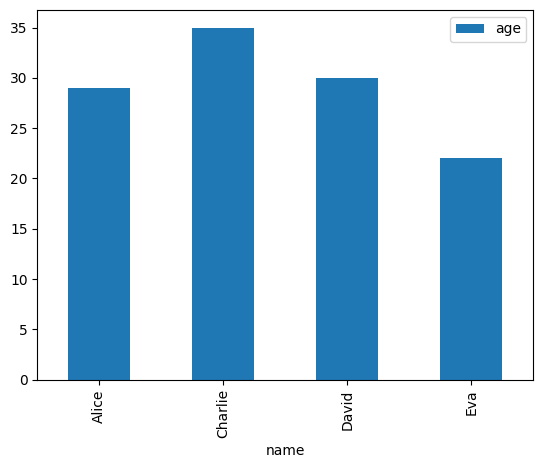

In [35]:
# Load data from database and plot
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_sql_query("SELECT name, age FROM users", conn)

df.plot(kind='bar', x='name', y='age')
plt.show()